# Feature engineering

In the previous episode, we look deep into the dataset, remove a couple of features and normalized the rest. In this episode, we will futher reduce the number of features and also make new helpful features using feature engineering.

In [41]:
import sys
sys.path.append('scripts')

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from process import load_dataset, preprocess_data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB

sb.set_style('dark')

Let's start by first loading the data. A simple script has been made to automate the process of data loading, cleaning, and normalization.

In [2]:
data = preprocess_data(load_dataset('data/train.csv', 'data/train_target.csv'))

## Baseline model

To see what progress we'll make using feature engineering, let's train a baseline model to which we can later compare. We'll use a simple cross-validated logistic regression. To keep things fast, we'll train the model on a subset of the whole dataset.

In [17]:
baseline_data = data.sample(80000)
scores = cross_val_score(LogisticRegression(), baseline_data.drop('target', axis=1), baseline_data.target, scoring='f1_macro')

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
scores.mean()

0.44487788153060742

## Principal component analysis

PCA is used to reduce the dimensionality of the dataset. Let's use it on the dataset.

In [5]:
data.shape

(761179, 43)

In [6]:
data_pca = pd.DataFrame(PCA(0.95).fit_transform(data.drop('target', axis=1)))
data_pca['target'] = data.target
data_pca.shape

(761179, 23)

Now let's peak into the new features, for example, what distribution they have.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ff0b7b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x110bb0128>]], dtype=object)

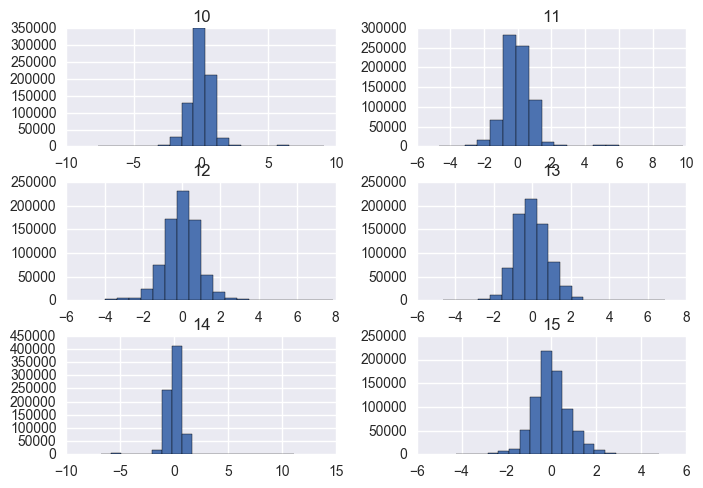

In [7]:
data_pca[data_pca.columns[10:16]].hist(bins=20)

They appear to have normal distribution. Now train another logistic regression model using this new data.

*NOTE: I tried running this with `n_jobs=-1`. This makes it run in parallel, utilizing all available cores. However, it almost always crashed in one process with segmentation fault.*

In [23]:
pca_data = data_pca.sample(80000)
pca_scores = cross_val_score(LogisticRegression(), pca_data.drop('target', axis=1), pca_data.target, scoring='f1_macro')

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
pca_scores.mean()

0.31024670020192724

While it runs faster, the final score is worse, at least on the training data. And `0.31` is pretty bad score anyway.

## Using random forest for selecting features

Random forests can be used for selecting features because they assign feature importances when trained. These can be used to filter unimportant features.

In [32]:
tree = DecisionTreeClassifier().fit(data.drop('target', axis=1), data.target)
data_tree = pd.DataFrame(SelectFromModel(tree, prefit=True).transform(data.drop('target', axis=1)))
data_tree['target'] = data.target

In [33]:
data_tree.shape

(761179, 13)

In [36]:
tree_data = data_tree.sample(80000)
tree_scores = cross_val_score(LogisticRegression(), tree_data.drop('target', axis=1), tree_data.target, scoring='f1_macro')

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
tree_scores.mean()

0.20583234183081167

Again, pretty bad on the testing data. The model is probably too complex for logistic regression. Just for fun, let's see how a decision tree will perform on PCA and decision tree selected features.

In [38]:
pca_scores = cross_val_score(DecisionTreeClassifier(), pca_data.drop('target', axis=1), pca_data.target, scoring='f1_macro')
tree_scores = cross_val_score(DecisionTreeClassifier(), tree_data.drop('target', axis=1), tree_data.target, scoring='f1_macro')

In [39]:
pca_scores.mean()

0.65832876360443515

In [40]:
tree_scores.mean()

0.81007723445550772

Good! Decision tree works much better for this dataset. Finally, let's try naive bayes and then we'll move to training models and ensemble learning.

In [42]:
pca_scores = cross_val_score(GaussianNB(), pca_data.drop('target', axis=1), pca_data.target, scoring='f1_macro')
tree_scores = cross_val_score(GaussianNB(), tree_data.drop('target', axis=1), tree_data.target, scoring='f1_macro')

In [43]:
pca_scores.mean()

0.42148513954070488

In [44]:
tree_scores.mean()

0.39784017079274675